## Name: Ankit Tripathi
## USC ID: 4612676999
## Github : AnkitTripathi45

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import warnings
import splitfolders
warnings.filterwarnings('ignore')
from random import sample
import math
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,BatchNormalization,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_curve,auc,plot_confusion_matrix,classification_report

In [2]:
from keras.preprocessing.image import ImageDataGenerator

#### Creating Training, Validation, Test data

In [3]:
file_path = '../Data/Classes.xlsx'
df_for_classes = pd.read_excel(file_path)
df_for_classes


,Folder Name,Class
0,005.Crested_Auklet,0
1,013.Bobolink,1
2,015.Lazuli_Bunting,2
3,023.Brandt_Cormorant,3
4,040.Olive_sided_Flycatcher,4
5,041.Scissor_tailed_Flycatcher,5
6,067.Anna_Hummingbird,6
7,072.Pomarine_Jaeger,7
8,076.Dark_eyed_Junco,8
9,081.Pied_Kingfisher,9


##### Create folders for Train validation test

In [4]:
splitfolders.ratio("../Data/images",'../Data/output',seed=1337,ratio=(0.715,0.16,0.125),group_prefix=None, move=False) 

Copying files: 1176 files [00:00, 2144.14 files/s]


#### Augmenting and resizing of Train dataset

In [5]:
train_datagen=ImageDataGenerator(zoom_range=0.2,brightness_range=(0.2,0.7),horizontal_flip=True,vertical_flip=True,rotation_range=30)
train_values=train_datagen.flow_from_directory('../Data/output/train',target_size=(224,224),batch_size=32,class_mode='categorical',shuffle=True)

Found 827 images belonging to 20 classes.


#### Augmenting and resizing of Validation dataset

In [6]:
validation_datagen=ImageDataGenerator()
val_values=validation_datagen.flow_from_directory('../Data/output/val',target_size=(224,224),batch_size=32,class_mode='categorical',shuffle=True)

Found 178 images belonging to 20 classes.


#### Augmenting and resizing of Test dataset

In [7]:
test_datagen=ImageDataGenerator()
test_values=test_datagen.flow_from_directory('../Data/output/test',target_size=(224,224),batch_size=32,class_mode='categorical',shuffle=False)

Found 171 images belonging to 20 classes.


### fitting VGG16

In [8]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

for layer in vgg16.layers:
    layer.trainable=False

model = tf.keras.models.Sequential([
        vgg16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1024, activation ='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(20, activation='softmax')
])

2022-12-12 04:20:06.164456: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-12 04:20:06.164573: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2


In [9]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 20)                20500     
                                                        

In [11]:
vgg_best=ModelCheckpoint(
    filepath='../weights/lease_loss_vgg.h5',
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    verbose=1
)

In [12]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10,restore_best_weights=True)


In [13]:

history=model.fit(train_values,epochs=50,shuffle=True,callbacks=[early_stop,vgg_best],validation_data=(val_values))

Epoch 1/50


2022-12-12 04:20:06.884603: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-12 04:20:07.256656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - ETA: 0s - loss: 6.6214 - accuracy: 0.2866

2022-12-12 04:20:17.360125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 36.00859, saving model to ../weights/lease_loss_vgg.h5
26/26 [==============================] - 13s 470ms/step - loss: 6.6214 - accuracy: 0.2866 - val_loss: 36.0086 - val_accuracy: 0.4270
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 4.0791 - accuracy: 0.5429
Epoch 2: val_loss improved from 36.00859 to 24.52597, saving model to ../weights/lease_loss_vgg.h5
26/26 [==============================] - 12s 460ms/step - loss: 4.0791 - accuracy: 0.5429 - val_loss: 24.5260 - val_accuracy: 0.5000
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 3.1364 - accuracy: 0.6530
Epoch 3: val_loss did not improve from 24.52597
26/26 [==============================] - 12s 448ms/step - loss: 3.1364 - accuracy: 0.6530 - val_loss: 25.8707 - val_accuracy: 0.5112
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 2.7564 - accuracy: 0.7013
Epoch 4: val_loss improved from 24.52597 to 22.09326, saving model to ../weig

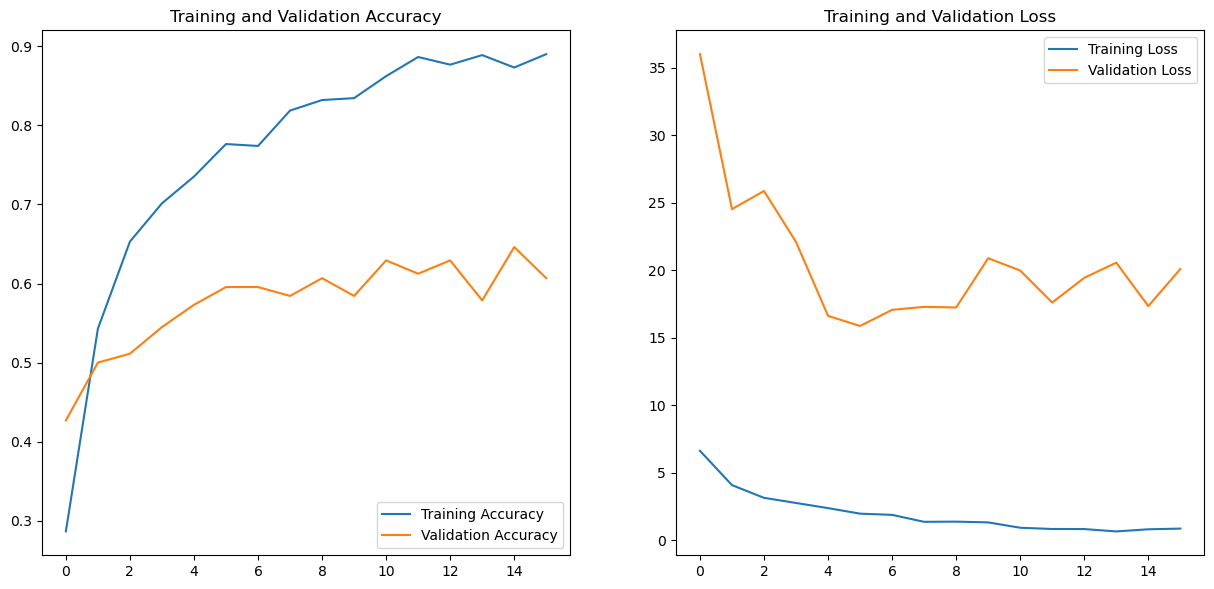

In [14]:
accuracy_vgg16 = history.history['accuracy']
val_accuracy_vgg16 = history.history['val_accuracy']
loss_vgg16 = history.history['loss']
val_loss_vgg16 = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(list(range(len(history.history['accuracy']))), accuracy_vgg16, label='Training Accuracy')
plt.plot(list(range(len(history.history['accuracy']))),val_accuracy_vgg16,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(list(range(len(history.history['accuracy']))), loss_vgg16, label='Training Loss')
plt.plot(list(range(len(history.history['accuracy']))), val_loss_vgg16, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

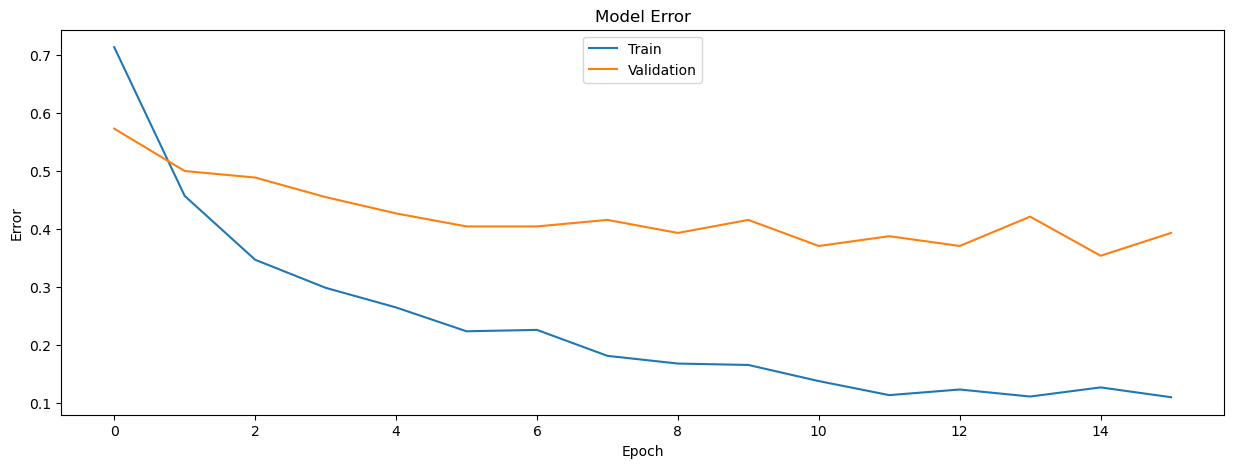

In [15]:
train_accuracy_vgg16=[1-x for x in history.history['accuracy']]
validation_accuracy_vgg16=[1-x for x in history.history['val_accuracy']]

plt.figure(figsize=(15,5))
plt.plot(train_accuracy_vgg16)
plt.plot(validation_accuracy_vgg16)
plt.title('Model Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper center')

In [16]:
predict_vgg16=model.predict_generator(test_values)

2022-12-12 04:23:18.877087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [17]:
yclass_vgg16=predict_vgg16.argmax(axis=1)

In [18]:
print('Classification Report for VGG16')
target_names = ['005.Crested_Auklet','013.Bobolink','015.Lazuli_Bunting','023.Brandt_Cormorant','040.Olive_sided_Flycatcher','041.Scissor_tailed_Flycatcher','067.Anna_Hummingbird','072.Pomarine_Jaeger','076.Dark_eyed_Junco','081.Pied_Kingfisher','082.Ringed_Kingfisher','086.Pacific_Loon','099.Ovenbird','104.American_Pipit','127.Savannah_Sparrow','135.Bank_Swallow','141.Artic_Tern','149.Brown_Thrasher','156.White_eyed_Vireo','168.Kentucky_Warbler']
print(classification_report(yclass_vgg16, test_values.classes, target_names=target_names))

Classification Report for VGG16
                               precision    recall  f1-score   support

           005.Crested_Auklet       0.50      0.75      0.60         4
                 013.Bobolink       0.67      0.86      0.75         7
           015.Lazuli_Bunting       0.75      0.75      0.75         8
         023.Brandt_Cormorant       0.62      0.42      0.50        12
   040.Olive_sided_Flycatcher       0.44      0.33      0.38        12
041.Scissor_tailed_Flycatcher       0.56      0.62      0.59         8
         067.Anna_Hummingbird       0.89      0.89      0.89         9
          072.Pomarine_Jaeger       0.56      0.83      0.67         6
          076.Dark_eyed_Junco       0.78      0.54      0.64        13
          081.Pied_Kingfisher       0.67      0.86      0.75         7
        082.Ringed_Kingfisher       0.56      0.71      0.63         7
             086.Pacific_Loon       0.44      1.00      0.62         4
                 099.Ovenbird       0.67    

### EfficientNetB0

### train datagen efficientNetB0

In [19]:
train_efficient_gen=ImageDataGenerator(rotation_range=60, 
                                        width_shift_range=0.25, 
                                        height_shift_range=0.25, 
                                        brightness_range=(0.5,0.7), 
                                        shear_range=0.4, 
                                        zoom_range=0.25,
                                        horizontal_flip=True, 
                                        vertical_flip=True)
train_values_efficient=train_efficient_gen.flow_from_directory('../Data/output/train',target_size=(224,224),batch_size=32,class_mode='categorical',shuffle=True)

Found 827 images belonging to 20 classes.


### validation datagen efficientNetB0

In [20]:
validation_efficient_gen=ImageDataGenerator()
validation_values_efficient=validation_efficient_gen.flow_from_directory('../Data/output/val',target_size=(224,224),batch_size=32,class_mode='categorical',shuffle=True)

Found 178 images belonging to 20 classes.


### test datagen efficientNetB0

In [21]:
test_efficient_gen=ImageDataGenerator()
test_values_efficient=test_efficient_gen.flow_from_directory('../Data/output/test',target_size=(224,224),batch_size=1,class_mode='categorical',shuffle=False)

Found 171 images belonging to 20 classes.


### EficientNetB0

In [22]:
effB0 = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3),pooling='Max')

for layer in effB0.layers:
    layer.trainable=False

model2 = tf.keras.models.Sequential([
        effB0,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(1024, activation ='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(20, activation='softmax')
])

In [23]:
model2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 batch_normalization_1 (Batc  (None, 62720)            250880    
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1024)              64226304  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 20)                20500     
                                                      

In [25]:
early_stop_effb0=EarlyStopping(monitor='val_loss',
                              patience=10,
                              verbose=1,
                              mode='min')

In [26]:
effb0_best=ModelCheckpoint(
    filepath='../weights/best_loss_EffB0.h5',
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    verbose=1
)

In [27]:
history2=model2.fit(train_values_efficient,epochs=50,shuffle=True,batch_size=32,callbacks=[early_stop_effb0,effb0_best],validation_data=(validation_values_efficient))

Epoch 1/50


2022-12-12 04:23:25.413127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - ETA: 0s - loss: 20.6543 - accuracy: 0.2805

2022-12-12 04:23:34.238556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 12.92813, saving model to ../weights/best_loss_EffB0.h5
26/26 [==============================] - 13s 388ms/step - loss: 20.6543 - accuracy: 0.2805 - val_loss: 12.9281 - val_accuracy: 0.5618
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 16.8467 - accuracy: 0.4849
Epoch 2: val_loss improved from 12.92813 to 10.61126, saving model to ../weights/best_loss_EffB0.h5
26/26 [==============================] - 9s 329ms/step - loss: 16.8467 - accuracy: 0.4849 - val_loss: 10.6113 - val_accuracy: 0.6573
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 15.4508 - accuracy: 0.5320
Epoch 3: val_loss improved from 10.61126 to 9.66999, saving model to ../weights/best_loss_EffB0.h5
26/26 [==============================] - 9s 321ms/step - loss: 15.4508 - accuracy: 0.5320 - val_loss: 9.6700 - val_accuracy: 0.6910
Epoch 4/50
26/26 [==============================] - ETA: 0s - loss: 13.7583 - accuracy: 0.5816
Epoch 4: val_loss imp

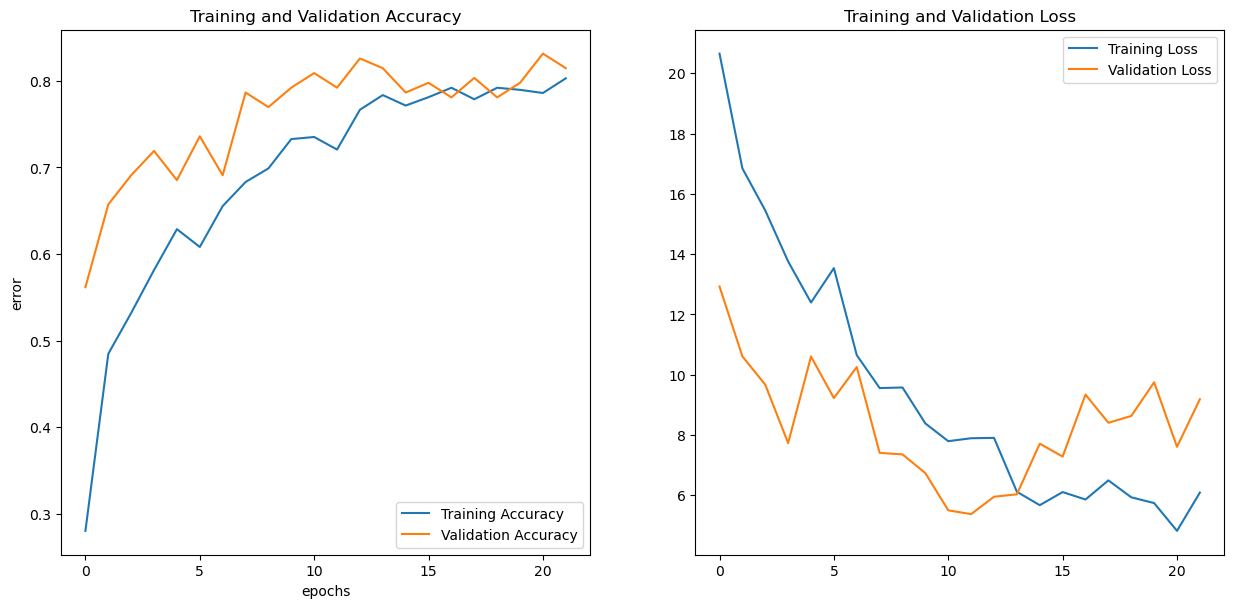

In [29]:
accuracy_effb0 = history2.history['accuracy']
val_accuracy_effb0 = history2.history['val_accuracy']
loss_effb0 = history2.history['loss']
val_loss_effb0 = history2.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(list(range(len(history2.history['accuracy']))), accuracy_effb0, label='Training Accuracy')
plt.plot(list(range(len(history2.history['accuracy']))),val_accuracy_effb0,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel("error")
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(list(range(len(history2.history['accuracy']))), loss_effb0, label='Training Loss')
plt.plot(list(range(len(history2.history['accuracy']))), val_loss_effb0, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

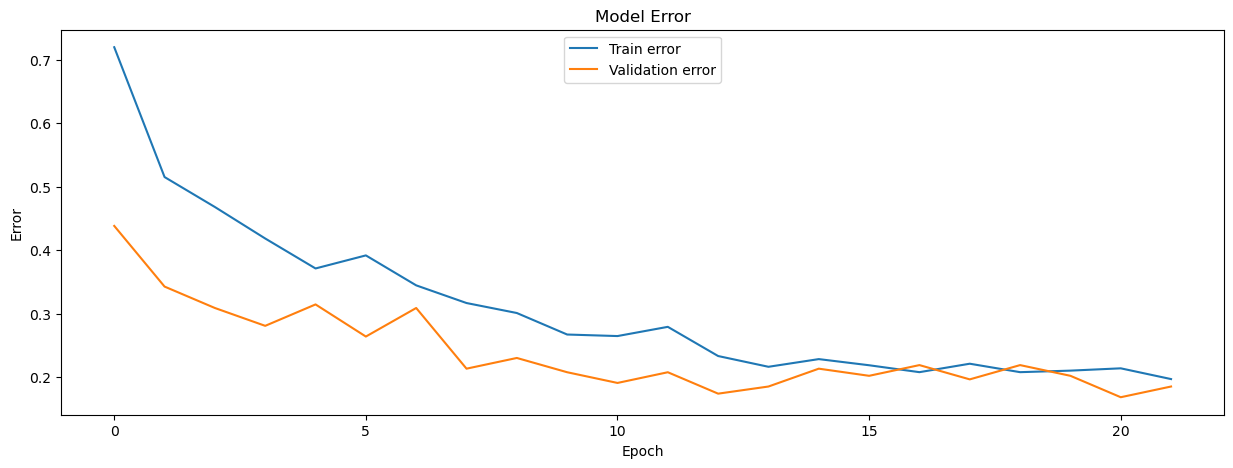

In [30]:
train_accuracy_effb0=[1-x for x in history2.history['accuracy']]
validation_accuracy_effb0=[1-x for x in history2.history['val_accuracy']]

plt.figure(figsize=(15,5))
plt.plot(train_accuracy_effb0)
plt.plot(validation_accuracy_effb0)
plt.title('Model Error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train error', 'Validation error'], loc='upper center')

In [31]:
predict_effb0=model2.predict_generator(test_values_efficient,steps=len(test_values_efficient))

2022-12-12 04:27:47.626328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [32]:
yclass_effb0=predict_effb0.argmax(axis=1)
yclass_effb0

array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,
        2,  2,  2,  2,  2,  2,  3,  7,  3,  3,  3,  3,  3,  3,  5,  4,  4,
        4,  4,  4,  4,  4,  4, 17,  5, 16, 17, 15,  5,  5, 18,  5,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7, 16,  7,  7,  7,  8,
        8,  8,  8,  8,  8, 12,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
       10, 10, 10, 10, 10, 10, 10, 10,  1, 11, 11, 11, 11,  3, 11, 11, 11,
       11, 17, 12, 12, 12, 14, 14, 12, 13, 12, 14, 13, 13, 13, 14, 13, 13,
       14, 17, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15,  3,  8,  4, 15, 15,
        8, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 12, 17, 17, 17,
       17, 18, 18, 18, 19, 18, 18, 19, 18, 18, 19, 19, 19, 19, 19, 19, 19,
       19])

In [33]:
print('Classification Report for EfficientNetB0')
target_names = ['005.Crested_Auklet','013.Bobolink','015.Lazuli_Bunting','023.Brandt_Cormorant','040.Olive_sided_Flycatcher','041.Scissor_tailed_Flycatcher','067.Anna_Hummingbird','072.Pomarine_Jaeger','076.Dark_eyed_Junco','081.Pied_Kingfisher','082.Ringed_Kingfisher','086.Pacific_Loon','099.Ovenbird','104.American_Pipit','127.Savannah_Sparrow','135.Bank_Swallow','141.Artic_Tern','149.Brown_Thrasher','156.White_eyed_Vireo','168.Kentucky_Warbler']
print(classification_report(yclass_effb0, test_values_efficient.classes, target_names=target_names))

Classification Report for EfficientNetB0
                               precision    recall  f1-score   support

           005.Crested_Auklet       1.00      1.00      1.00         6
                 013.Bobolink       1.00      0.90      0.95        10
           015.Lazuli_Bunting       1.00      1.00      1.00         8
         023.Brandt_Cormorant       0.88      0.78      0.82         9
   040.Olive_sided_Flycatcher       0.89      0.89      0.89         9
041.Scissor_tailed_Flycatcher       0.44      0.80      0.57         5
         067.Anna_Hummingbird       1.00      1.00      1.00         9
          072.Pomarine_Jaeger       0.89      0.89      0.89         9
          076.Dark_eyed_Junco       0.89      0.80      0.84        10
          081.Pied_Kingfisher       1.00      1.00      1.00         9
        082.Ringed_Kingfisher       0.89      1.00      0.94         8
             086.Pacific_Loon       0.89      1.00      0.94         8
                 099.Ovenbird      